# Principal Components Analysis (PCA)

The problems in this notebook touch on principal components analysis. In particular this material corresponds to `Lectures/Unsupervised Learning/Dimension Reduction/1. Principal Components Analysis`.

In [1]:
## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

##### 1. Lines of best fit

Karl Pearson's 1903 paper, <a href = "https://www.tandfonline.com/doi/abs/10.1080/14786440109462720"><i>On lines and planes of closest fit to systems of points in space</i></a>, was the original introduction of PCA.

In this paper Pearson contemplated what we mean by line (or plane) of best fit. In regression the approach is to find the line of best fit by minimizing the distance between the estimate, $\hat{y}$, and the actual value, $y$. Pearson wondered what if instead we considered minimizing the distance between the data points and the hyperplane fit to those points.

In the case of simple linear regression this translates to minimizing the collective length of the red lines pictured below.

In [2]:
x = 2*np.random.random(50) - 1
y = x + .25*np.random.randn(50)

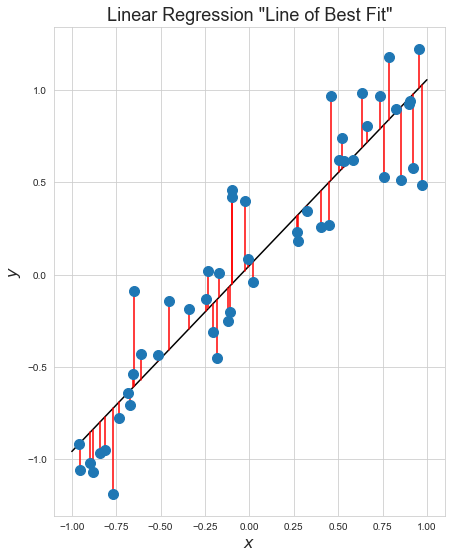

In [3]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(x.reshape(-1,1), y)

plt.figure(figsize=(7,9))



plt.plot(np.linspace(-1,1,100), 
         slr.predict(np.linspace(-1,1,100).reshape(-1,1)), 
         'k',
         zorder=1)

for i in range(50):
    plt.plot([x[i],x[i]],
             [y[i],slr.predict([[x[i]]])[0]],
             'r-',
             zorder=1)
    
plt.scatter(x,y,s=100,zorder=50)

plt.title('Linear Regression "Line of Best Fit"', fontsize=18)
plt.xlabel("$x$", fontsize=16)
plt.ylabel("$y$", fontsize=16)

plt.show()

For PCA on 2 features Pearson proposed minimizing the length of the red lines in this image.

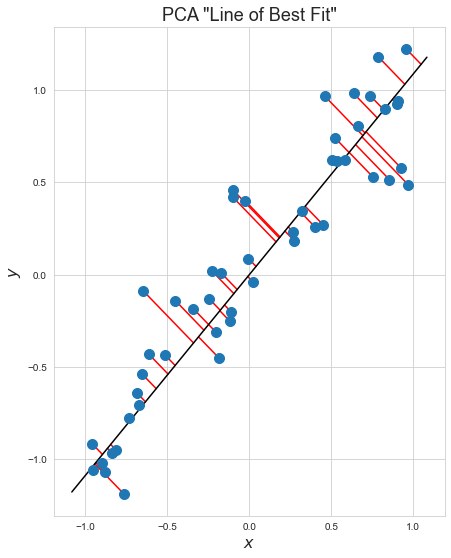

In [4]:
from sklearn.decomposition import PCA
pca = PCA()

X = np.zeros((50,2))
X[:,0] = x
X[:,1] = y
pca.fit(X)

plt.figure(figsize=(7,9))

plt.plot([-1.6*pca.components_[0][0], 1.6*pca.components_[0][0]],
            [-1.6*pca.components_[0][1], 1.6*pca.components_[0][1]],
            'k')

for i in range(50):
    plt.plot([x[i],X[i,:].dot(pca.components_[0])*pca.components_[0][0]],
             [y[i],X[i,:].dot(pca.components_[0])*pca.components_[0][1]],
             'r-',
             zorder=1)
    
plt.scatter(x,y,s=100,zorder=50)

plt.title('PCA "Line of Best Fit"', fontsize=18)
plt.xlabel("$x$", fontsize=16)
plt.ylabel("$y$", fontsize=16)

plt.show()

A similar image can be found in Pearson's paper,

<img src = "PearsonLine.png" width = "500"></img>

It turns out that this formulation is equivalent to maximizing the variance.

Read through page 352 here, <a href="https://www.stat.cmu.edu/~cshalizi/uADA/12/lectures/ch18.pdf">https://www.stat.cmu.edu/~cshalizi/uADA/12/lectures/ch18.pdf</a> for a derivation of that fact.

##### While reading write any notes you would like here



##### 2. The Relationship of PCA to SVD

Recall that the PCA component vectors are given by the eigenvectors of $\Sigma$, the covariance matrix of the data matrix $X$, where the columns of $X$ have all been centered at $0$.

Any covariance matrix is symmetric, and thus is diagonalizable. So $\Sigma = Q \Lambda Q^T$, for some matrix $Q$, where $\Lambda$ is a diagonal matrix of eigenvalues and $Q$ is a matrix of eigenvectors.

In a potential abuse of notation let $X = U \sigma V^T$ be the singular value decomposition of $X$.

Now recall that the sample covariance matrix can be computed as $X^T X$.

Recalculate $X^T X$ substituting in the SVD of $X$, what do you find? Hint: $V$ is orthonormal.

##### Answer

$$
X^T = (U \sigma V^T)^T = V \sigma U^T
$$
so
$$
X^T X = V \sigma^2 V^T.
$$

Now note that
$$
\Sigma = Q \Lambda Q^T = V \sigma^2 V^T,
$$
where both $\Lambda$ and $\sigma^2$ are diagonal matrices. However, diagonalizations of a matrix are unique up to permutation of the diagonal matrix entries and scaling of the exterior matrices.

Thus the eigenvalues of $\Sigma$ are equal to the square of the singular values of $X$ and the principal component vectors are equivalent to the columns of $V^T$.



It is actually much safer to calculate the SVD of $X$ rather than find the eigenvectors of $X^T X$, and this is what `sklearn` does.

##### 3. Kernel PCA

PCA can fail to be useful to supervised learning problems when it is applied to nonlinear data, meaning data where the regression relationship is nonlinear or the decision boundary is nonlinear.

When learning about support vector machines we learned about the "kernel trick", whose underlying principle is that we can lift nonlinear data into a higher dimensionsal space in which the data becomes linear. This same idea can be applied to PCA. <i>Kernel PCA</i> involves lifting the data to a higher dimensional space and then applying regular PCA on the lifted data. Luckily this can again be accomplished with the kernel trick.

Kernel PCA can be implemented in `sklearn` with `KernelPCA`, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html">https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html</a>.

##### 4. PCA Handles Multicolinearity

Here's a very simple example of how PCA can be helpful in regression tasks.

In [5]:
X = np.zeros((1000,2))

X[:,0] = 4*np.random.randn(1000)
X[:,1] = 2*X[:,0] + np.random.randn(1000)

y = X[:,0] + 12 + X[:,1] + 1.5*np.random.randn(1000)

What is the correlation, if any, between the `0` and `1` columns of `X`?

In [6]:
np.corrcoef(X[:,0], X[:,1])

array([[1.        , 0.99153155],
       [0.99153155, 1.        ]])

When features in $X$ are highly correlated with one another this is referred to as <i>multicolinearity</i>. Multicollinearity in a set of regression features can cause your coefficient estimates to have increased variance, and in general your estimates are not very stable to small changes in the model. Moreover, feature sets with high multicolinearity result in close to singular feature matrices, which can cause computational issues.

PCA is one way to address multicolinearity because it takes your features and produces a new set of orthogonal features which have to be uncorrelated, because they are orthogonal.

First make a scatter matrix that include the features contained in `X` and the target, `y`. Then run the feature matrix through PCA and plot the PCA projected feature matrix along with the target in a new scatter matrix.

In [7]:
df = pd.DataFrame({'x1':X[:,0],'x2':X[:,1],'y':y})

In [8]:
from pandas.plotting import scatter_matrix

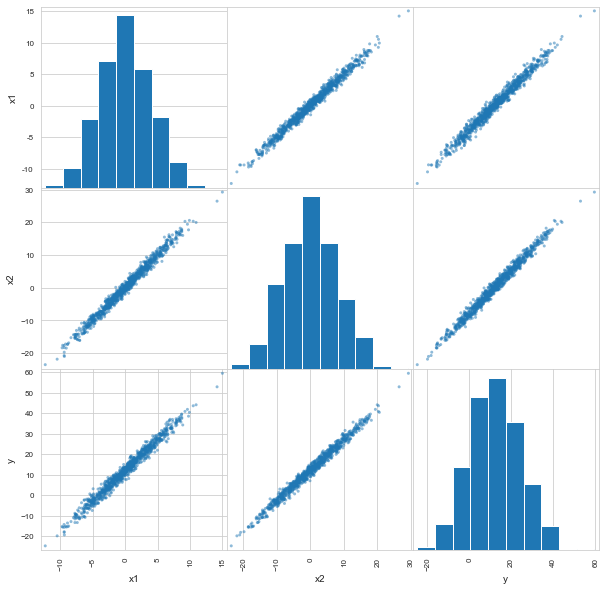

In [9]:
scatter_matrix(df, figsize = (10,10))

plt.show()

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [11]:
## Code here
pipe = Pipeline([('scaler',StandardScaler()),
                    ('pca',PCA(2))])

pipe.fit(X)

fit = pipe.transform(X)

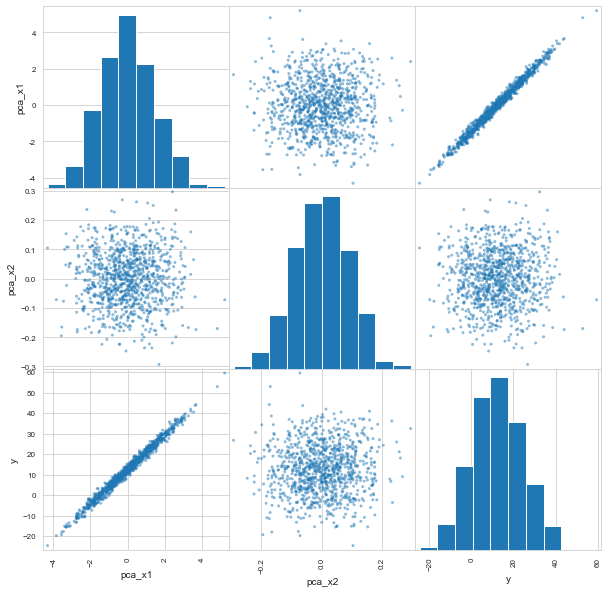

In [12]:
## Code here
new_df = pd.DataFrame({'pca_x1':fit[:,0],'pca_x2':fit[:,1],'y':y})


scatter_matrix(new_df, figsize = (10,10))

plt.show()

##### 5. P(olitical) Components Analysis

Read in the data `Senate_115_roll_mat.csv` below. Note you will need to unzip this data file in your repository first.

This data set contains the roll call votes for the 115th Senate. Each row represents a senator and the results of all of their roll call votes. The roll call votes are contained in columns labeled `1` through `599`.


Run the vote columns through PCA with 2 components. Plot the fitted data colored by their `party_code`. What do you find?

In [13]:
votes = pd.read_csv("Senate_115_roll_mat.csv")

In [14]:
votes.head()

,name,icpsr,party_code,1,2,3,4,5,6,7,...,590,591,592,593,594,595,596,597,598,599
0,"GRASSLEY, Charles Ernest",14226,200,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0
1,"LEAHY, Patrick Joseph",14307,100,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,...,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0
2,"MARKEY, Edward John",14435,100,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,...,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0
3,"HATCH, Orrin Grant",14503,200,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,0.0
4,"NELSON, Clarence William (Bill)",14651,100,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,...,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0


In [15]:
## Code here
pca = PCA(2)

pca.fit(votes[[str(i) for i in range(1,600)]])

fit = pca.transform(votes[[str(i) for i in range(1,600)]])

votes_pca = pd.DataFrame({'party_code':votes['party_code'].copy()})
votes_pca['pca_1'] = fit[:,0]
votes_pca['pca_2'] = fit[:,1]

In [16]:
votes.party_code.value_counts()

200    29351
100    26955
328     1198
Name: party_code, dtype: int64

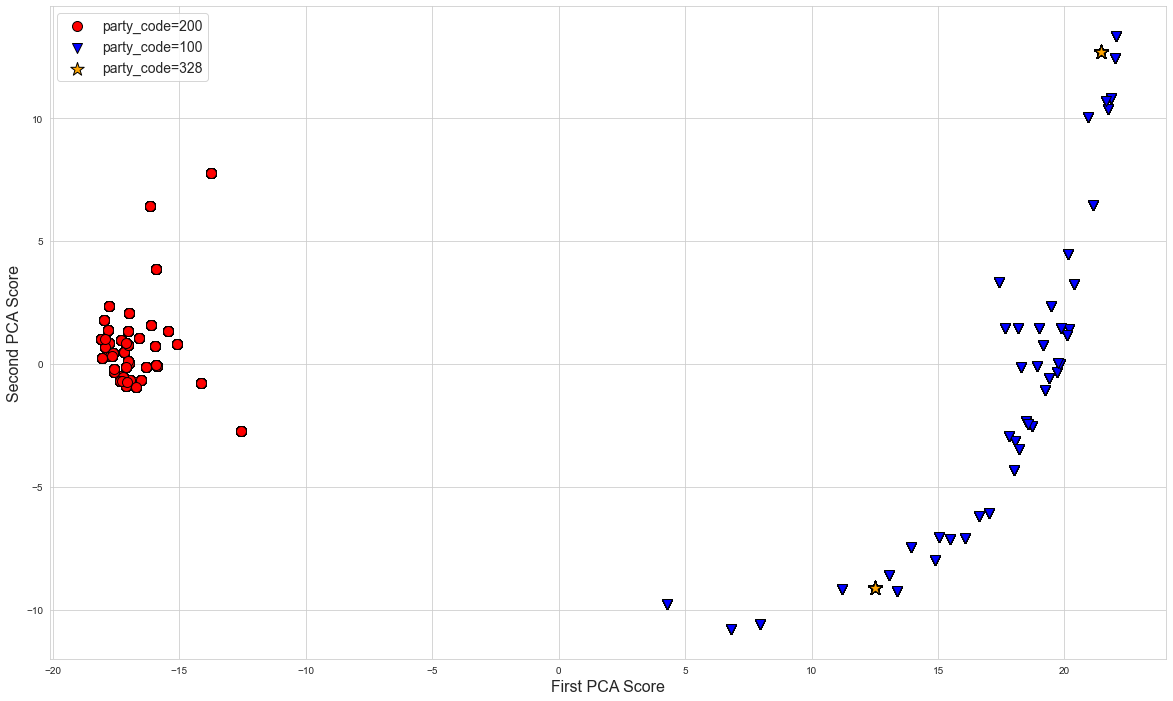

In [17]:
## Code here

plt.figure(figsize=(20,12))

plt.scatter(votes_pca.loc[votes_pca.party_code==200].pca_1,
               votes_pca.loc[votes_pca.party_code==200].pca_2,
               s=100, 
               c='r',
               label='party_code=200',
               edgecolor='k')
plt.scatter(votes_pca.loc[votes_pca.party_code==100].pca_1,
               votes_pca.loc[votes_pca.party_code==100].pca_2,
               s=100, 
               c='b',
               label='party_code=100',
               marker='v',
               edgecolor='k')
plt.scatter(votes_pca.loc[votes_pca.party_code==328].pca_1,
               votes_pca.loc[votes_pca.party_code==328].pca_2,
               s=200, 
               c='orange',
               label='party_code=328',
               marker='*',
               edgecolor='k')

plt.xlabel("First PCA Score", fontsize=16)
plt.ylabel("Second PCA Score", fontsize=16)

plt.legend(fontsize=14)

plt.show()

##### 6. Introducing MNIST

We first introduce the MNIST data set. Load in the data below.

In [18]:
from sklearn.datasets import load_digits

mnist = load_digits()

X = mnist['data']
y = mnist['target']

Each observation in this data set represents an 8x8 grayscale pixel grid of a handwritten digit from $0$-$9$. We visualize the first 10 observations below. Each pixel has a minimum value of $0$ and a maximum value of $255$.

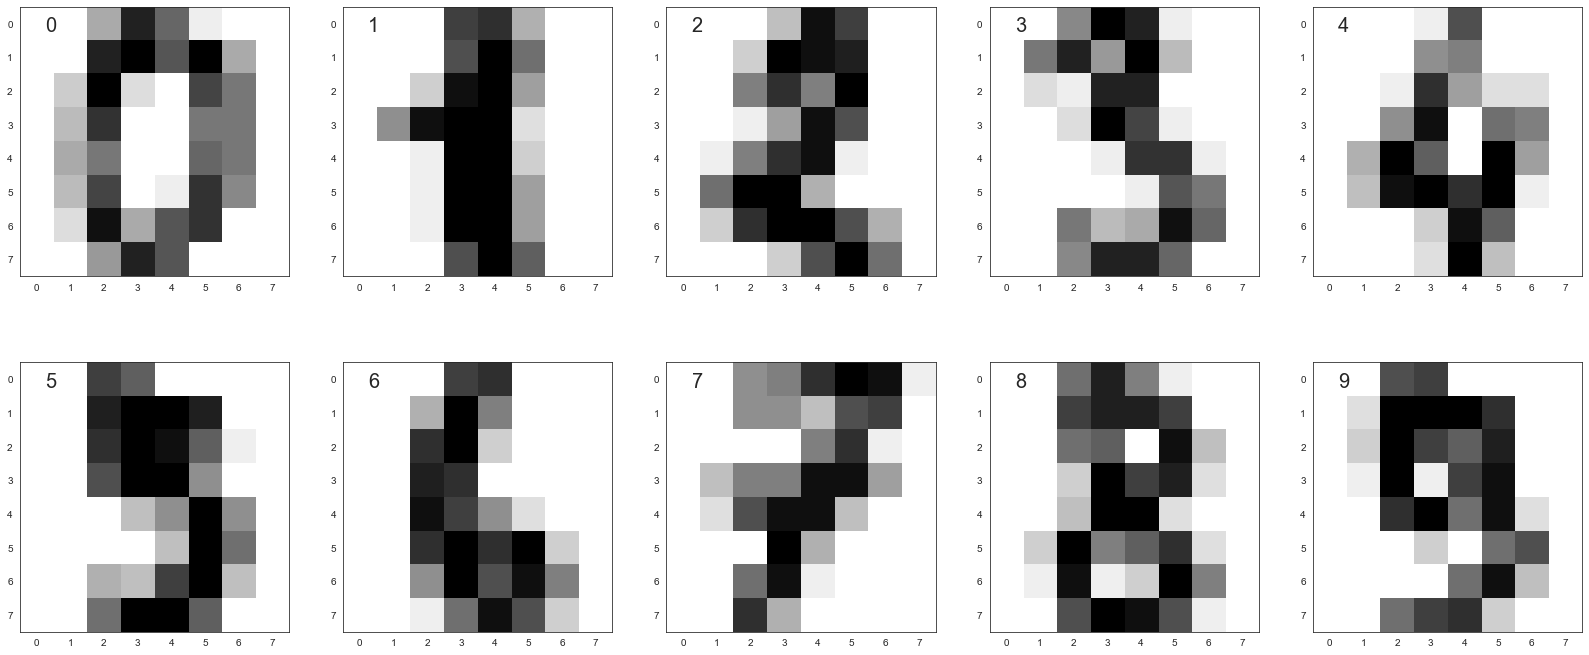

In [19]:
sns.set_style("white")

fig,ax = plt.subplots(2,5,figsize=(28,12))

for i in range(10):
    ax[i//5,i%5].imshow(X[i,:].reshape(8, 8), cmap='gray_r')
    ax[i//5,i%5].text(.25,.25,str(y[i]),fontsize=20)

plt.show()

There is a lot of white space in these images. This indicates that we may be able to get away without needing all of the features.

Look at the explained variance ratio. What seems like a good number of dimensions to you?

In [20]:
## first scale the data
X_scale = X/255

In [21]:
## Code here
pca = PCA()

pca.fit(X_scale)

PCA()

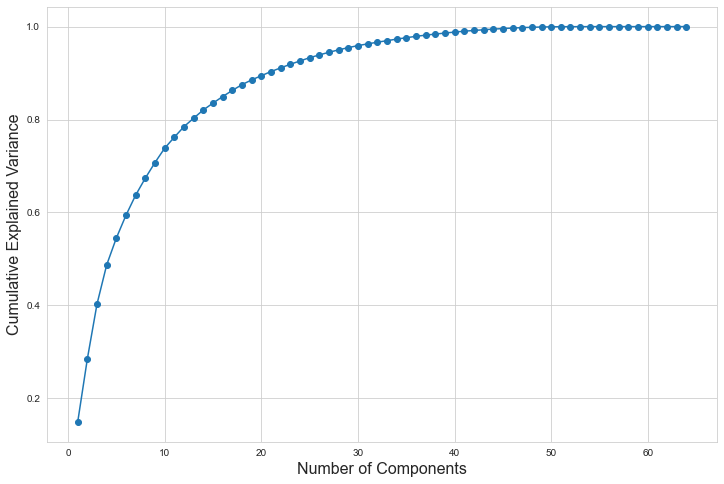

In [22]:
sns.set_style("whitegrid")
plt.figure(figsize=(12,8))

plt.plot(range(1,pca.n_components_+1), np.cumsum(pca.explained_variance_ratio_),'-o')

plt.xlabel("Number of Components", fontsize=16)
plt.ylabel("Cumulative Explained Variance", fontsize=16)

plt.show()

Anywhere in $20$ to $30$ dimensions seems reasonable to me.

Now actually run `X` through PCA. Plot the first two components coloring the dots by their actual digit. Does it look like PCA does a good job of separating the data?

In [23]:
fit = pca.transform(X_scale)[:,:2]

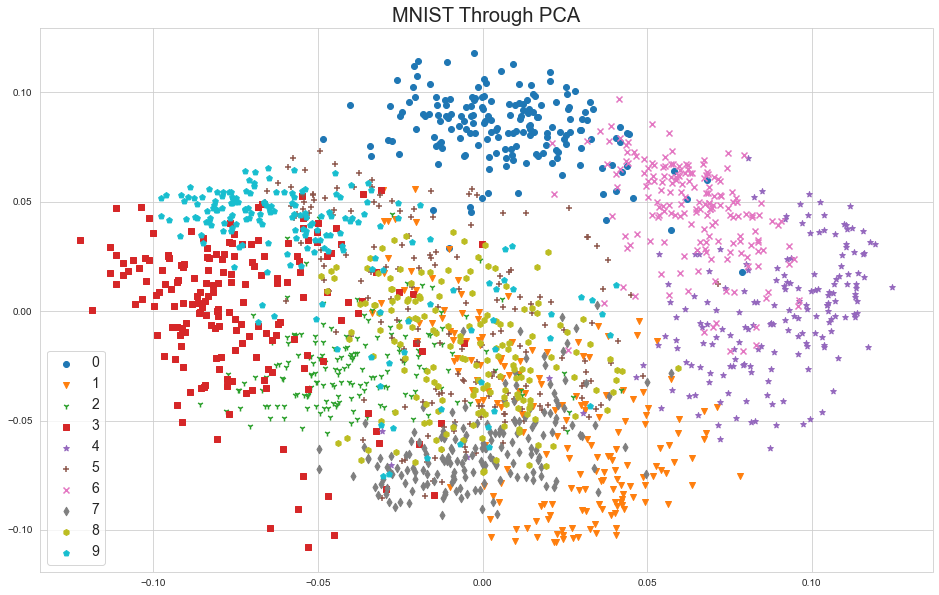

In [24]:
## Code here
marker_dict = {0:'o',
                  1:'v',
                  2:'1',
                  3:'s',
                  4:'*',
                  5:'+',
                  6:'x',
                  7:'d',
                  8:'h',
                  9:'p'}

plt.figure(figsize=(16,10))

for i in range(10):
    plt.scatter(fit[y==i,0], 
                fit[y==i,1], 
                marker = marker_dict[i],
                label=i)

plt.legend(fontsize=14)
plt.title("MNIST Through PCA", fontsize=20)

plt.show()

It does not!

Now perform dimension reduction using Linear Discriminant Analysis instead. Plot the project down to the first two LDA directions, do you think this does a better job than the PCA at separating the data through a 2-D projection? 

In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [26]:
LDA = LinearDiscriminantAnalysis()

LDA.fit(X_scale,y)

lda_fit = LDA.transform(X_scale)

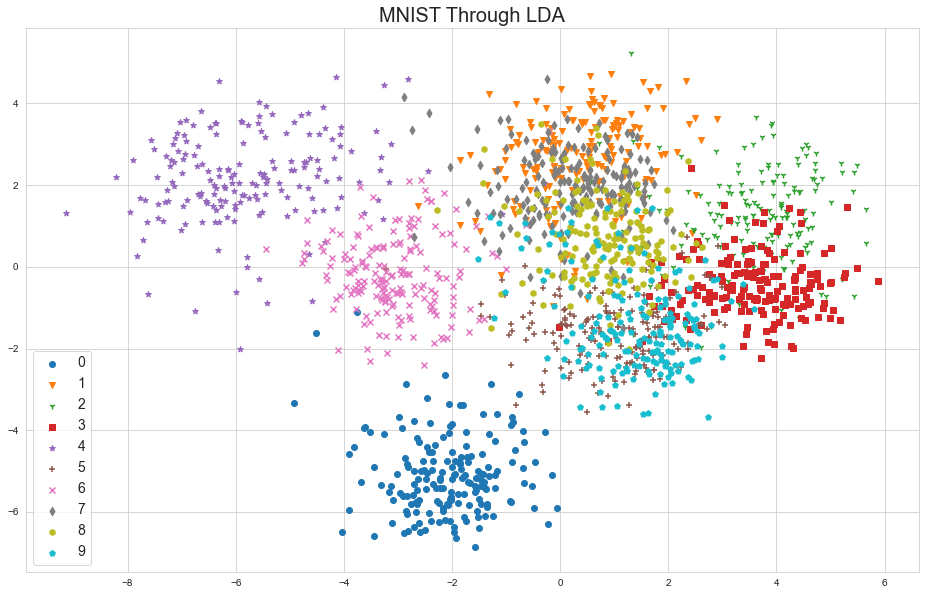

In [27]:
## Code here
marker_dict = {0:'o',
                  1:'v',
                  2:'1',
                  3:'s',
                  4:'*',
                  5:'+',
                  6:'x',
                  7:'d',
                  8:'h',
                  9:'p'}

plt.figure(figsize=(16,10))

for i in range(10):
    plt.scatter(lda_fit[y==i,0], 
                lda_fit[y==i,1], 
                marker = marker_dict[i],
                label=i)

plt.legend(fontsize=14)
plt.title("MNIST Through LDA", fontsize=20)

plt.show()

Only slightly better.

Now try applying `KernelPCA` with the radial basis function kernel.

In [28]:
from sklearn.decomposition import KernelPCA

In [29]:
kernel_pca = KernelPCA(kernel='rbf')

kernel_pca.fit(X_scale)

kernel_fit = kernel_pca.transform(X_scale)

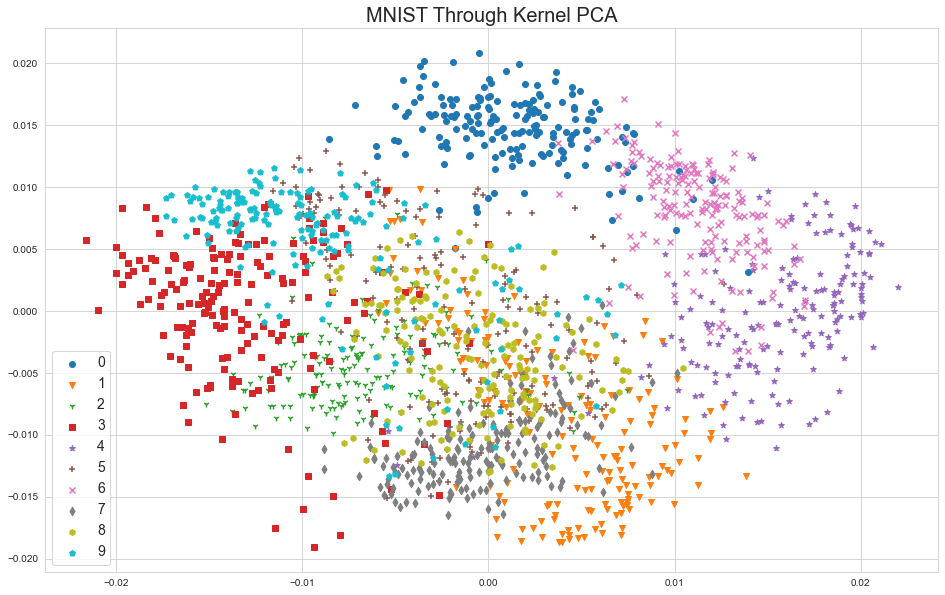

In [30]:
marker_dict = {0:'o',
                  1:'v',
                  2:'1',
                  3:'s',
                  4:'*',
                  5:'+',
                  6:'x',
                  7:'d',
                  8:'h',
                  9:'p'}

plt.figure(figsize=(16,10))

for i in range(10):
    plt.scatter(kernel_fit[y==i,0], 
                kernel_fit[y==i,1], 
                marker = marker_dict[i],
                label=i)

plt.legend(fontsize=14)
plt.title("MNIST Through Kernel PCA", fontsize=20)

plt.show()

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)